# Convolution is fast

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import cv2

from timeit              import default_timer as timer
from skimage             import img_as_float

from scipy.optimize import minimize

%matplotlib inline

In [2]:
n = 28
m = 28

rx, ry = np.arange(0,n, 1), np.arange(0,m, 1)
gx, gy = np.meshgrid(rx, ry) 
# Pair up elems from gx and gy to create array of pairs 
X_2D = np.c_[gx.ravel(), gy.ravel()]

In [3]:
def kernel(X1, X2, l=1, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    Args:
        X1     : Array of m points (m x d).  We'll have d = 1 or 2. For images we have d = 2.
        X2     : Array of n points (n x d).
        l      : lenght-scale, default is 1
        sigma_f: vertical variation, default is 1
    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-(1/(2*l**2)) * sqdist)

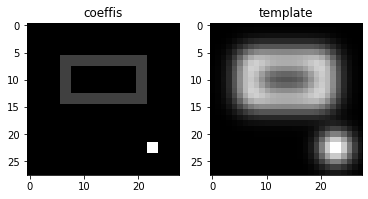

In [4]:
a = np.zeros((n,m))
a[6:15,6:22] = 1
a[8:13,8:20] = 0
a[22:24,22:24] = 4

Mix = kernel(X_2D,X_2D,2)@a.ravel()

plt.subplot(1,2,1)
plt.imshow(a, cmap = 'gray');
plt.title("coeffis")
plt.subplot(1,2,2)
plt.imshow(Mix.reshape(a.shape[0],a.shape[1]), cmap = 'gray');
plt.title("template");

Notice that `kernel(X_2D,X_2D,2)@a.ravel()` computes a convolution. The convolution kernel is the Gaussian, i.e.

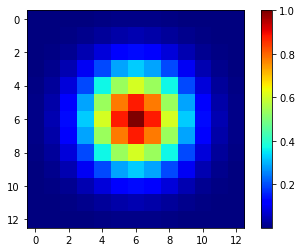

In [5]:
l = 2
c = 6  # actually should depend on bandwith l 

x   = np.arange(0, 2*c + 1)
RBF = np.exp( -  (1/(2*l**2))  * (x - c)**2 )  
RBF2 = np.outer(RBF,RBF)
plt.imshow(RBF2, cmap = 'jet')
plt.colorbar();

Let $*$ denote convolution. Then the Fourier transform turns convolution into pointwise multiplication $\widehat{f *g} = \hat{f}\cdot\hat{g}$. Thus the fast way to calculate the convolution of $f$ and $g$ is to caclulate the inverse fourier transform of the pointwise product of $\hat{f}$ with $\hat{g}$. This is fast because the discrete fourier transform has a fast implementation, called the fft (fast fourier transform), which utilizes properties of $e^{2\pi i x}$.

In [6]:
from scipy import signal

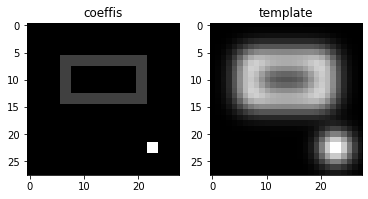

In [7]:
Conv = signal.fftconvolve(a, RBF2, mode='same')

plt.subplot(1,2,1)
plt.imshow(a, cmap = 'gray');
plt.title("coeffis")
plt.subplot(1,2,2)
plt.imshow(Conv, cmap = 'gray');
plt.title("template");

The upshot is that now the computational cost does not grow quadratic with the image size. For any size image we always convolve with the same size small Gaussian kernel.

(333, 350)

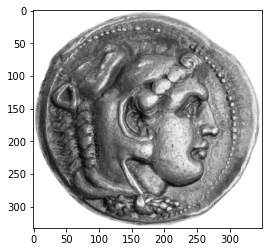

In [8]:
img = cv2.imread('testcoin.jpg',0)
img = img_as_float(img) 
plt.imshow(img, cmap = 'gray');
img.shape

0.013473900000001038


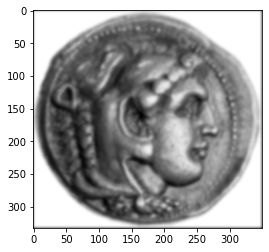

In [9]:
start = timer()
Conv = signal.fftconvolve(img, RBF2, mode='same')
end = timer()   
print(end - start)
plt.imshow(Conv, cmap = 'gray');

So this takes 0.017 seconds, whereas in the matrix multiplication way we would have to multiply the image with a kernel matrix of dimension $333^2\times350^2$, i.e. more that $110.000\times110.000$.